# Simulation of the 2D Ising Model

One of the most fascinating phenomena in nature is ferromagnetism. A ferromagnetic (FM) material exhibits a non-zero spontaneous magnetization even in the absence of an external magnetic field. This occurs below a well-defined critical temperature $T_c$, known as the Curie temperature. For $T > T_c$, the magnetization vanishes. Thus, $T_c$ separates two phases: a disordered phase for $T > T_c$ and a ferromagnetic phase for $T < T_c$.

Although the Ising model is simple, it captures much of the essential physics of the ferromagnetic phase transition. To explore this model, we will compute key physical quantities, including the mean energy $\langle E \rangle$, the mean magnetization $\langle M \rangle$, the heat capacity $C$, and the magnetic susceptibility $\chi$.

# The Ising Model

Consider a lattice with $N$ sites, where each site $i$ can take one of two possible states: $s_i = +1$ or $-1$, corresponding to spin “up” or “down.” A configuration (or microstate) of the system is fully specified by the set of spin values $\{s_1, s_2, \dots, s_N\}$.

The energy $E$ of a given microstate is determined by the configuration of spins. In the presence of a uniform magnetic field $h$, the total energy is given by the Ising Hamiltonian:

$$
E = -J \sum_{\langle ij \rangle} s_i s_j - h \sum_{i=1}^N s_i,
$$

where the first sum is over all nearest-neighbor pairs, and the second sum is over all lattice sites. The exchange constant $J$ measures the strength of spin–spin interactions. 

- If $J > 0$, aligned spins ($\uparrow\uparrow$ or $\downarrow\downarrow$) are energetically favored → **ferromagnetic**.
- If $J < 0$, anti-aligned spins ($\uparrow\downarrow$ or $\downarrow\uparrow$) are favored → **antiferromagnetic**.

The interaction with the magnetic field $h$ gives an energy contribution of $-h$ for spin up and $+h$ for spin down (assuming unit magnetic moment).

The dynamics do not follow Newton's laws. Instead, the system evolves through **spin flip processes**: a spin is randomly chosen and flipped ($\uparrow \leftrightarrow \downarrow$), with the transition accepted or rejected based on its energy change.

### Physical Quantities

The **magnetization** $M$ is the total magnetic moment of the system:

$$
M = \sum_{i=1}^N s_i.
$$

We are typically interested in the average magnetization $\langle M \rangle$ and its fluctuations, $\langle M^2 \rangle - \langle M \rangle^2$, as functions of temperature and external field.

Note: In the absence of a magnetic field, the system is equally likely to be in a state with all spins up or all spins down, so $\langle M \rangle \approx 0$. Therefore, we often compute $m = \sqrt{M^2}$ or $m = |M|$, which are always non-negative.

### The Heat Capacity

Heat capacity at constant field can be defined thermodynamically as:

$$
C = \frac{\partial \langle E \rangle}{\partial T}.
$$

Or, using energy fluctuations in the canonical ensemble:

$$
C = \frac{1}{(k_B T)^2} \left( \langle E^2 \rangle - \langle E \rangle^2 \right).
$$

### The Magnetic Susceptibility

The **magnetic susceptibility** $\chi$ measures the response of the system’s magnetization to a small external magnetic field:

$$
\chi = \lim_{H \to 0} \frac{\partial \langle M \rangle}{\partial H}.
$$

In the canonical ensemble, this can be computed from magnetization fluctuations:

$$
\chi = \frac{1}{k_B T} \left( \langle M^2 \rangle - \langle M \rangle^2 \right).
$$

# Metropolis Algorithm

### Moves

To evolve the system, we:
- Pick a random spin.
- Calculate the energy change $\Delta E$ that would result from flipping it.
- Accept or reject the flip based on the Metropolis criterion.

Energy for the spin at $(x, y)$ due to neighbors:

$$
E = J \cdot s(x, y) \left[ s(x+1, y) + s(x-1, y) + s(x, y+1) + s(x, y-1) \right]
$$

Then:

$$
\Delta E = 2E
$$

- If $\Delta E \le 0$, we **accept the flip**.
- If $\Delta E > 0$, we accept it **with probability** $\exp(-\Delta E / k_B T)$.

Since the sum in brackets ranges from $-4$ to $+4$, we can precompute and store all possible transition probabilities in a **lookup table**.

### Boundary Conditions

To approximate an infinite system, we use **periodic boundary conditions (PBC)**:
- In 1D, sites $1$ and $N$ are connected, forming a ring.
- In 2D, both $x$ and $y$ directions wrap around, giving the lattice the topology of a **torus**.

PBC ensures translational invariance and minimizes finite-size effects. However, it also reduces the minimum possible distance between two spins.

### Initial Conditions and Equilibration

- A common initial condition is a random spin configuration.
- However, equilibration (relaxation to steady state) may take significant time.
- A practical approachTricksse a previously equilibrated configuration at a nearby temperature to initialize a new run.

### Tricks

- Precompute and store transition probabilities and neighbor positions to avoid recalculating or generating excessive random numbers.
- If performing simulations at multiple temperatures, use the **same sequence of random numbers** across runs to reduce noise and correlate results.

### Exercise: Equilibration of the 2D Ising Model

1. Run your simulation with $L=10$ at $T=2$ starting from all spins up.  Plot the energy and magnetization as a function of time.  How long does it take to reach equilibrium?

2. Visually inspect several equilibrium configurations. Is the system ordered or disordered? What does that mean - to be disordered?

3. Repeat the simulation at $T=1.5$ with the same initial condition. How does the equilibration time compare?

4. Visually inspect equilibrium configurations at $T=1.5$. Are these configurations more or less ordered than at $T=2$?

5. Is the acceptance ratio an increasing or decreasing function of $T$?  
What does this tell you about the efficiency of the Metropolis algorithm at low temperatures?

6. Implement an simulated annealing process and measure/calculate the quantities $\langle E \rangle$, $\langle M \rangle$, $C_V$, $\chi$. Inspecting the graphs of these quantities, can you estimate the transition temperature of this system, $T_c$


## Implementation: first we set up a class for the Ising model itself, prior to any simulation.

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation

class Direction:
    RIGHT, TOP, LEFT, BOTTOM = range(4)
    
class Ising(object):
    
    def __init__ (self, L, J, T):
      
        self.L = L
        self.N = L * L
        self.TWOJ = 2. * J
        self.T = T
        self.beta = 1. / T
        
        # Initialize site positions and neighbors table
        self.nn = np.zeros(shape=(self.N, 4), dtype=np.int16)
        self.position = np.zeros(shape=(L, L), dtype=np.int16)
        self.x = np.zeros(self.N, dtype=np.int16)
        self.y = np.zeros(self.N, dtype=np.int16)

        # Periodic boundary conditions
        n = 0
        for iy in range(L):
            for ix in range(L):
                self.position[iy, ix] = n
                self.x[n] = ix
                self.y[n] = iy
                self.nn[n, Direction.LEFT] = n - 1
                self.nn[n, Direction.RIGHT] = n + 1
                self.nn[n, Direction.TOP] = n + L
                self.nn[n, Direction.BOTTOM] = n - L
                if ix == 0:
                    self.nn[n, Direction.LEFT] = n + L - 1
                if ix == L - 1:
                    self.nn[n, Direction.RIGHT] = n - (L - 1)
                if iy == 0:
                    self.nn[n, Direction.BOTTOM] = n + (L - 1) * L
                if iy == L - 1:
                    self.nn[n, Direction.TOP] = n - (L - 1) * L
                n += 1

        # Initialize spins
        r = np.random.random(self.N) * 2 - 1
        self.spin = np.ones(self.N, dtype=np.int16)
        self.spin[r < 0] = -1

        # Compute total magnetization and energy
        self.Mtot = np.sum(self.spin)
        self.E = -J * np.sum(self.spin * (
            self.spin[self.nn[:, Direction.RIGHT]] + 
            self.spin[self.nn[:, Direction.TOP]]
        ))

        # Transition probabilities
        # 3 for spins -1, 0, +1 indexing with +1 offset (for future 3 states)
        self.de = np.zeros(shape=(3, 9))  
        self.w = np.zeros(shape=(3, 9))
        self.set_temp(self.T)
                                                             
    def set_temp(self, T):
        self.T = T
        self.beta = 1. / T
        # Lookup tables for transition probabilities
        for spin_sum in range(-4, 5):
            self.de[0, spin_sum + 4] = -self.TWOJ * spin_sum
            self.de[2, spin_sum + 4] = self.TWOJ * spin_sum
            p = np.exp(-self.beta * self.de[0, spin_sum + 4])
            self.w[0, spin_sum + 4] = min(p, 1.)
            self.w[2, spin_sum + 4] = min(1. / p, 1.)
                                                             
    def metropolis(self):
        nchanges = 0
        #propose change site
        i = int(np.random.random() * self.N)
        #Gather neighbors
        ileft = self.nn[i, Direction.LEFT]
        iright = self.nn[i, Direction.RIGHT]
        itop = self.nn[i, Direction.TOP]
        ibottom = self.nn[i, Direction.BOTTOM]

        spin_sum = (self.spin[ileft] + self.spin[iright] +
                    self.spin[itop] + self.spin[ibottom])

        s = self.spin[i]
        deltaE = self.de[s + 1, spin_sum + 4]
        #change if favorable
        if deltaE <= 0. or np.random.random() < self.w[s + 1, spin_sum + 4]:
            self.spin[i] *= -1
            self.Mtot += 2 * (-s)
            self.E += deltaE
            nchanges += 1

        return nchanges


## Then we run to equilibrate at a set temperature

T =  2
<E>/N =  -1.53552
<E^2>/N =  2.4577536
<M>/N =  0.7756400000000001
<M^2>/N =  0.6466608
C= 0.024982982400000076
chi= 0.022521695199999914
Acceptance ratio =  0.0014566666666666667


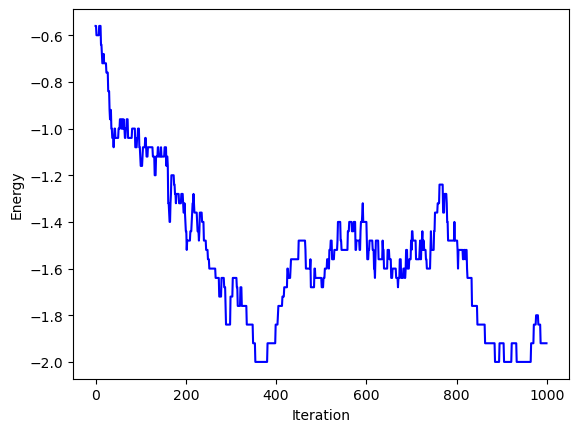

In [5]:
L=10
Nwarmup = 100
Nsteps = 1000
Ndecorr = 3
Temp = 2
J = 1.

S = Ising(L, J, Temp)
E = np.zeros(Nsteps)
M = np.zeros(Nsteps)

for i in range(Nwarmup):
    S.metropolis()

naccept = 0
for i in range(Nsteps):
    for n in range(Ndecorr):
        naccept += S.metropolis()
    E[i] = S.E
    M[i] = S.Mtot

E /= S.N
M /= S.N


Et = np.sum(E)/Nsteps
E2t = np.sum(E**2)/Nsteps
Mt = np.sum(M)/Nsteps
M2t = np.sum(M**2)/Nsteps

print("T = ", Temp)
print("<E>/N = ", Et)
print("<E^2>/N = ", E2t)
print("<M>/N = ", Mt)
print("<M^2>/N = ", M2t)
print("C=", (E2t-Et*Et)/Temp/Temp)
print("chi=", (M2t-Mt*Mt)/Temp)
print("Acceptance ratio = ", float(naccept)/S.N/Nsteps/Ndecorr)
        
pyplot.plot(np.arange(0,Nsteps,1),E,ls='-',c='blue');
pyplot.xlabel("Iteration")
pyplot.ylabel("Energy");

In [ ]:
pyplot.plot(np.arange(0,Nsteps,1),M,ls='-',c='red');
pyplot.xlabel("Iteration")
pyplot.ylabel("Magnetization");

## Complete Exercise
Program the appropriate steps to answer the questions above.